In [2]:
from math import fsum, exp, log
from copy import deepcopy
from data import load_synth, load_mnist
import random
import matplotlib.pyplot as plt
import numpy as np

# Part 2

## Helper Functions

In [1]:
def sigmoid(x):
    return 1/(1 + exp(-x))

def sigmoid_prime(x):
    return sigmoid(x) * (1 - sigmoid(x))

def softmax(x):
    return [exp(xi)/fsum([exp(xj) for xj in x]) for xi in x]

def softmax_prime(x):
    out = []
    for i, yi in enumerate(x):
        derivatives = []
        for j, yj in enumerate(x):
            if i == j:
                derivatives.append(yi * (1-yi))
            else:
                derivatives.append(-yi * yj)
        out.append(derivatives)
    return out
    
def apply_weights_and_biases(X, W, B):
    Y = [0.] * len(W[0])
    for j in range(len(Y)):
        for i in range(len(X)):
            Y[j] += W[i][j] * X[i]
        Y[j] += B[j]
    return Y

def cross_entropy(x, true_index):
    return -log(x[-true_index -1])

def cross_entropy_prime(Y, true_index):
    ret = [0.] * len(Y)
    ret[-true_index -1] = -1 / Y[-true_index-1]
    return ret

def mat_mul(a=[[1, 0],
               [0, 1]], b=[1, 1]):
    return [a[0][0] * b[0] + a[0][1] * b[1], a[1][0] * b[0] + a[1][1] * b[1]]

## Forward Pass

In [7]:
true_y = 1
# Input layer
X = [1., -1.]
# Bias weights for the input layer
B = [0., 0., 0.]
# Weights for the input layer
W = [
    [1., 1., 1.],
    [-1., -1., -1.]
]

# Hidden layer
K = apply_weights_and_biases(X, W, B)
H = [sigmoid(x) for x in K]
# Bias weights for the hidden layer
C = [0, 0]
# Weights for the next layer
V = [
    [1., 1.],
    [-1., -1.],
    [-1., -1.]
]

#Applying weights and biases
O = apply_weights_and_biases(K, V, C)

# Softmax layer
Y = softmax(O)
print(Y)
loss = cross_entropy(Y, true_y)
loss

[0.5, 0.5]


0.6931471805599453

## Q3: Backwards Pass

In [10]:
true_y = 1

print(f'Backpropagation Y={true_y}')
print()
alpha = 0.01

dl_dy = cross_entropy_prime(Y, true_index=true_y)
# Getting the gradient wrt to the true class
dy_do = softmax_prime(Y)
dl_do = mat_mul(dy_do, dl_dy)

dl_dv = deepcopy(V)
for i, hi in enumerate(H):
    for j, _ in enumerate(dl_dv[i]):
        dl_dv[i][j] = dl_do[j] * hi
print('dl / dv =', dl_dv)

do_dc = [1., 1.]
dl_dc = [x * y for x, y in zip(dl_do, do_dc)]
print('dl / dc =', dl_dc)

print()

do_dh = []
for i, oi in enumerate(O):
    doi_dh = []
    for j, hj in enumerate(H):
        doi_dh.append(V[j][i])
    do_dh.append(doi_dh)

dl_dh = [0] * len(H)
for i, hi in enumerate(H):
    for j, oj in enumerate(O):
        dl_dh[i] += do_dh[j][i] * dl_do[j]
    
dh_dk = [sigmoid_prime(x) for x in K]

dl_dk = [x * y for x, y in zip(dl_dh, dh_dk)]

dl_dw = deepcopy(W)
for i, xi in enumerate(X):
    for j, _ in enumerate(dl_dw[i]):
        dl_dw[i][j] = dl_dk[j] * xi
print('dl / dw =', dl_dw)

dh_db = [1., 1., 1.]
dl_db = [x * y for x, y in zip(dl_dh, dh_db)]
print('dl / db =', dl_db)

Backpropagation Y=1

dl / dv = [[-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116], [-0.44039853898894116, 0.44039853898894116]]
dl / dc = [-0.5, 0.5]

dl / dw = [[0.0, 0.0, 0.0], [-0.0, -0.0, -0.0]]
dl / db = [0.0, 0.0, 0.0]


In [9]:
dl_do

[-0.5, 0.5]

## Q4: Training Loop

In [1]:
from math import fsum, exp, log
from copy import deepcopy
from data import load_synth, load_mnist
import random
import matplotlib.pyplot as plt
import numpy as np

# loading the data\
(xtrain, ytrain), (xval, yval), num_cls = load_synth()

In [2]:
class DNN:
    def __init__(self, alpha=0.1):
        # Bias weights for the input layer
        self.B = [0., 0., 0.]
        # Weights for the input layer
        self.W = [[random.random() for _ in range(3)] for _ in range(2)]
        # Bias weights for the hidden layer
        self.C = [0, 0]
        # Weights for the next layer
        self.V = [[random.random() for _ in range(2)] for _ in range(3)]

        self.alpha = alpha
        
    def sigmoid(self, x):
        return 1/(1 + exp(-x))

    def sigmoid_prime(self, x):
        return self.sigmoid(x) * (1 - self.sigmoid(x))

    def softmax(self, x):
        return [exp(xi)/fsum([exp(xj) for xj in x]) for xi in x]

    def softmax_prime(self, x):
        out = []
        for i, yi in enumerate(x):
            derivatives = []
            for j, yj in enumerate(x):
                if i == j:
                    derivatives.append(yi * (1-yi))
                else:
                    derivatives.append(-yi * yj)
            out.append(derivatives)
        return out

    def apply_weights_and_biases(self, X, W, B):
        Y = [0.] * len(W[0])
        for j in range(len(Y)):
            for i in range(len(X)):
                Y[j] = fsum([Y[j], W[i][j] * X[i]])
            Y[j] = fsum([Y[j], B[j]])
        return Y

    def cross_entropy(self, x, true_index):
        return -log(x[-true_index -1])

    def cross_entropy_prime(self, Y, true_index):
        ret = [0.] * len(Y)
        ret[-true_index -1] = -1 / Y[-true_index-1]
        return ret

    def mat_mul(self, a=[[1, 0],
                   [0, 1]], b=[1, 1]):
        return [a[0][0] * b[0] + a[0][1] * b[1], a[1][0] * b[0] + a[1][1] * b[1]]

    def train(self, X, true_y):
        self.K = self.apply_weights_and_biases(X, self.W, self.B)
        self.H = [self.sigmoid(x) for x in self.K]
        self.O = self.apply_weights_and_biases(self.K, self.V, self.C)
        self.Y = self.softmax(self.O)
        prediction = list(self.Y).index(max(self.Y))
        loss = self.cross_entropy(self.Y, true_y)


        dl_dy = self.cross_entropy_prime(self.Y, true_index=true_y)
        # Getting the gradient wrt to the true class
        dy_do = self.softmax_prime(self.Y)
        dl_do = self.mat_mul(dy_do, dl_dy)

        dl_dv = deepcopy(self.V)
        for i, hi in enumerate(self.H):
            for j, _ in enumerate(dl_dv[i]):
                dl_dv[i][j] = dl_do[j] * hi

        do_dc = [1., 1.]
        dl_dc = [x * y for x, y in zip(dl_do, do_dc)]

        do_dh = []
        for i, oi in enumerate(self.O):
            doi_dh = []
            for j, hj in enumerate(self.H):
                doi_dh.append(self.V[j][i])
            do_dh.append(doi_dh)

        dl_dh = [0] * len(self.H)
        for i, hi in enumerate(self.H):
            for j, oj in enumerate(self.O):
                dl_dh[i] += do_dh[j][i] * dl_do[j]

        dh_dk = [self.sigmoid_prime(x) for x in self.K]

        dl_dk = [x * y for x, y in zip(dl_dh, dh_dk)]

        dl_dw = deepcopy(self.W)
        for i, xi in enumerate(X):
            for j, _ in enumerate(dl_dw[i]):
                dl_dw[i][j] = dl_dk[j] * xi
                
        dh_db = [1., 1., 1.]
        dl_db = [x * y for x, y in zip(dl_dh, dh_db)]
        # Updating the weights
        for i, vi in enumerate(dl_dv):
            for j, dvij in enumerate(vi):
                self.V[i][j] = self.V[i][j] - (self.alpha * dvij)
        for i, wi in enumerate(dl_dw):
            for j, dwij in enumerate(wi):
                self.W[i][j] = self.W[i][j] - (self.alpha * dwij)
        # Updating the biases
        for i, dci in enumerate(dl_dc):
            self.C[i] = self.C[i] - (self.alpha * dci)
        for i, dbi in enumerate(dl_db):
            self.B[i] = self.B[i] - (self.alpha * dbi)
        return loss, prediction

    def epoch(self, xtrain, ytrain, epochs=1):
        losses = []
        predictions = []
        for ep in range(epochs):
            for x, y in zip(xtrain, ytrain):
                loss, prediction = self.train(x, y)
                losses.append(loss)
                predictions.append(prediction)
        return losses, predictions

In [8]:
random.seed(42)
dnn = DNN(alpha=0.05)

losses, predictions = dnn.epoch(xtrain / np.linalg.norm(xtrain), ytrain, epochs=1)

In [13]:
# To train with only one instance
random.seed(4)
dnn = DNN(alpha=0.01)
losses, predictions = dnn.epoch([[1, 0]], [0], epochs=1000)

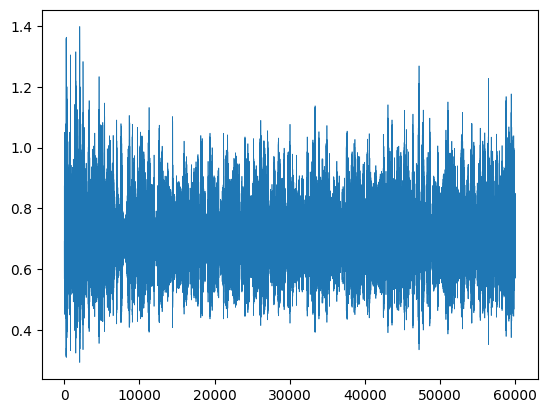

In [9]:
plt.plot(losses, linewidth=0.5)

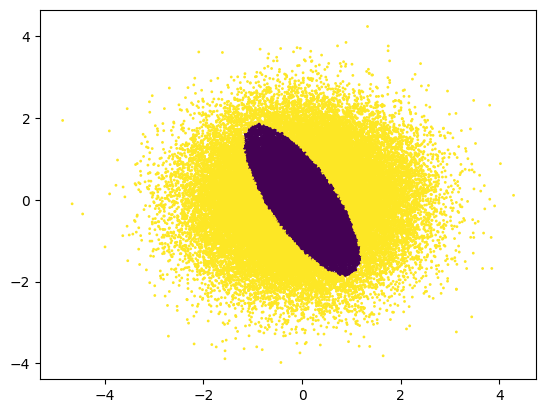

In [5]:
xs = [x[0] for x in xtrain]
ys = [x[1] for x in xtrain]
plt.scatter(xs, ys, c=ytrain, s=1)